In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from collections import defaultdict

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.dummy import *

# 1.3 Regressors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.dummy import DummyRegressor
import seaborn as sns
import pickle
from scipy.stats import spearmanr
from sklearn.inspection import permutation_importance
import time
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
df1 = pd.read_csv('ferm.csv', index_col=0, low_memory=False)
df2 = pd.read_csv('multiome_all.csv', index_col=0, low_memory=False)

In [3]:
df = df1.join(df2, lsuffix='_ferm', rsuffix='_resp')

In [4]:
cln = df.dropna()
cln.shape

(937, 350)

In [5]:
protein = cln.loc[cln['Molecule Type_ferm'].isin(['Protein'])]
protein = protein.drop(columns=['Molecule Type_ferm', 'Molecule Type_resp'])
protein.shape

(873, 348)

In [6]:
lipid = cln.loc[cln['Molecule Type_ferm'].isin(['Lipid'])]
lipid = lipid.drop(columns=['Molecule Type_ferm', 'Molecule Type_resp'])
lipid.shape

(50, 348)

In [7]:
met = cln.loc[cln['Molecule Type_ferm'].isin(['Metabolite'])]
met = met.drop(columns=['Molecule Type_ferm', 'Molecule Type_resp'])
met.shape

(14, 348)

# make full X data (proteins with KNN imputation)

In [8]:

pf = df.loc[df['Molecule Type_ferm'].isin(['Protein'])]
pf = pf.drop(columns = ['Molecule Type_ferm', 'Molecule Type_resp'])
kimpp = KNNImputer(n_neighbors=2)
pfi = kimpp.fit_transform(pf)
X_data = np.asarray(pfi.T)
X_df = pd.DataFrame(data = pfi.T, index = pf.T.index, columns = pf.T.columns)

# Make lipid data

In [9]:
lf = df.loc[df['Molecule Type_ferm'].isin(['Lipid'])]
lf = lf.drop(columns = ['Molecule Type_ferm', 'Molecule Type_resp'])
kimpl = KNNImputer(n_neighbors=2)
lfi = kimpl.fit_transform(lf)
l_data = np.asarray(lfi.T)
l_df = pd.DataFrame(data = lfi.T, index = lf.T.index, columns = lf.T.columns)

# Make metabolite data

In [10]:
mf = df.loc[df['Molecule Type_ferm'].isin(['Metabolite'])]
mf = mf.drop(columns = ['Molecule Type_ferm', 'Molecule Type_resp'])
kimpm = KNNImputer(n_neighbors=2)
mfi = kimpm.fit_transform(mf)
m_data = np.asarray(mfi.T)
m_df = pd.DataFrame(data = mfi.T, index = mf.T.index, columns = mf.T.columns)

# Make X_data and y_data from the matrix

In [11]:
ml_df = l_df.join(m_df)
ml_data = np.asarray(ml_df)

# Split train/test

In [12]:
train_index, test_index= train_test_split(range(len(X_data)),
                                                              test_size = 0.10, 
                                                              random_state = 42)
print(len(train_index))
print(len(test_index))

313
35


In [13]:
## replace this with the using indexes
pro_train_all, pro_test, met_train_all, met_test = train_test_split(X_df, 
                                                              m_df, 
                                                              test_size = 0.10, 
                                                              random_state = 42)

pro_train_all, pro_test, lip_train_all, lip_test = train_test_split(X_df,
                                                                      l_df,
                                                                      test_size = 0.10,
                                                                      random_state = 42)

pro_train_all, pro_test, ml_train_all, ml_test = train_test_split(X_df,
                                                                      ml_df,
                                                                      test_size = 0.10,
                                                                      random_state = 42)

pro_train, pro_val, met_train, met_val = train_test_split(pro_train_all, met_train_all, 
                                                          test_size = 0.11, random_state = 42)

pro_train, pro_val, lip_train, lip_val = train_test_split(pro_train_all, lip_train_all,
                                                          test_size = 0.11, random_state = 42)


print('Training Prot Shape:', pro_train.shape)
print('Training met Shape:', met_train.shape)
print('Training lip Shape:', lip_train.shape)

print('Training lip Shape:', ml_train_all.shape)

print('Validation Prot Shape:', pro_val.shape)
print('Validation met Shape:', met_val.shape)
print('Validation met Shape:', lip_val.shape)

print('Testing Prot Shape:', pro_test.shape)
print('Testing met Shape:', met_test.shape)
print('Testing lip Shape:', lip_test.shape)

Training Prot Shape: (278, 3690)
Training met Shape: (278, 273)
Training lip Shape: (278, 54)
Training lip Shape: (313, 327)
Validation Prot Shape: (35, 3690)
Validation met Shape: (35, 273)
Validation met Shape: (35, 54)
Testing Prot Shape: (35, 3690)
Testing met Shape: (35, 273)
Testing lip Shape: (35, 54)


# START HERE to Load saved data

In [37]:
# doesnt come back with column names - need to save as pandas dataframes
'''pro_train_all = np.loadtxt('protein_train_all.txt')
pro_train = np.loadtxt('protein_train.txt')
pro_val = np.loadtxt('protein_val.txt')
pro_test  = np.loadtxt('protein_test.txt')

met_train_all = np.loadtxt('metabolite_train_all.txt')
met_train = np.loadtxt('metabolite_train.txt')
met_val = np.loadtxt('metabolite_val.txt')
met_test = np.loadtxt('metabolite_test.txt')

lip_train_all = np.loadtxt('lipid_train_all.txt')
lip_train = np.loadtxt('lipid_train.txt')
lip_val = np.loadtxt('lipid_val.txt')
lip_test = np.loadtxt('lipid_test.txt')'''

"pro_train_all = np.loadtxt('protein_train_all.txt')\npro_train = np.loadtxt('protein_train.txt')\npro_val = np.loadtxt('protein_val.txt')\npro_test  = np.loadtxt('protein_test.txt')\n\nmet_train_all = np.loadtxt('metabolite_train_all.txt')\nmet_train = np.loadtxt('metabolite_train.txt')\nmet_val = np.loadtxt('metabolite_val.txt')\nmet_test = np.loadtxt('metabolite_test.txt')\n\nlip_train_all = np.loadtxt('lipid_train_all.txt')\nlip_train = np.loadtxt('lipid_train.txt')\nlip_val = np.loadtxt('lipid_val.txt')\nlip_test = np.loadtxt('lipid_test.txt')"

In [14]:
import seaborn as sns

In [15]:
def model_eval(model, model_name, XTRAIN, XTEST,YTRAIN, YTEST):
    model.fit(XTRAIN, YTRAIN)
    YPRED = model.predict(XTEST)
    print('Mean squared error: %.4f'
      % mean_squared_error(YTEST, YPRED))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.4f'
      % r2_score(YTEST, YPRED))
    # Plot outputs
    plt.rcParams['figure.figsize'] = 5,5
    #sns.jointplot(YTEST, YPRED,  color='black', kind='reg')
    plt.scatter(YTEST, YPRED, color='blue')
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.subplots_adjust(top=0.9)
    plt.suptitle(model_name, fontsize = 16)
    plt.show()
    return mean_squared_error(YTEST, YPRED), r2_score(YTEST, YPRED)

In [16]:
## try many models
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
model_dict = {
    'dummy': DummyRegressor(),
    'linear': LinearRegression(),
    'lasso' : Lasso(),
    'elastic': ElasticNet(),
    'ridge': Ridge(),
    'Sup Vec Regr': MultiOutputRegressor(SVR()),
    'M/O adaB': MultiOutputRegressor(AdaBoostRegressor()),
    'M/O gboost': MultiOutputRegressor(GradientBoostingRegressor()) , 
    'ExtraTrees': ExtraTreesRegressor(),
    'RandomForest' : RandomForestRegressor()
}

# Now metabolite data

fold=0
Mean squared error: 0.1022
Coefficient of determination: -0.0115


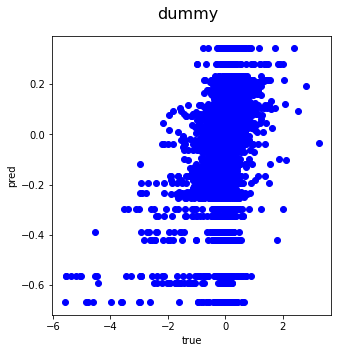

Mean squared error: 0.0437
Coefficient of determination: 0.2782


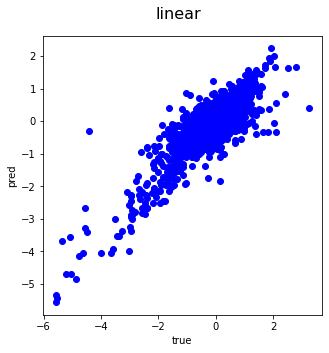

Mean squared error: 0.0818
Coefficient of determination: 0.0007


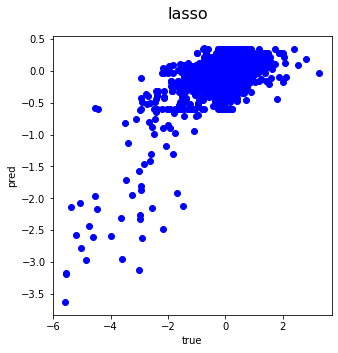

Mean squared error: 0.0711
Coefficient of determination: 0.0157


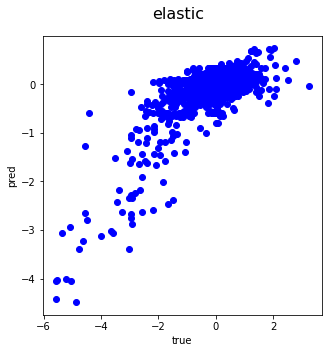

Mean squared error: 0.0436
Coefficient of determination: 0.2818


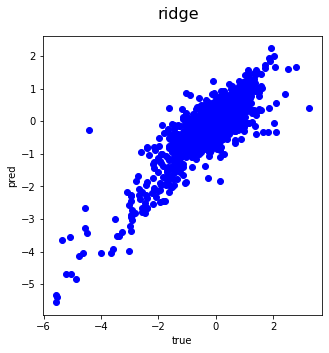

Mean squared error: 0.0425
Coefficient of determination: 0.3591


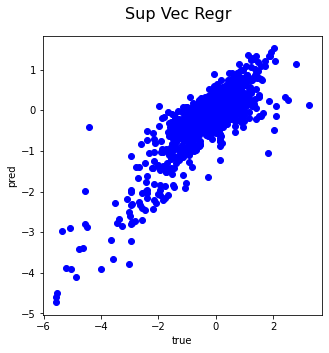

Mean squared error: 0.0445
Coefficient of determination: 0.3510


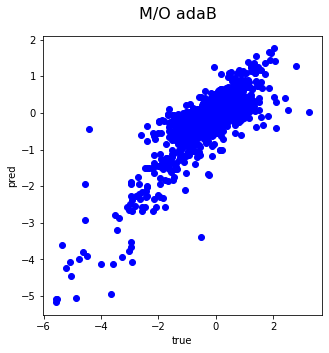

Mean squared error: 0.0424
Coefficient of determination: 0.3542


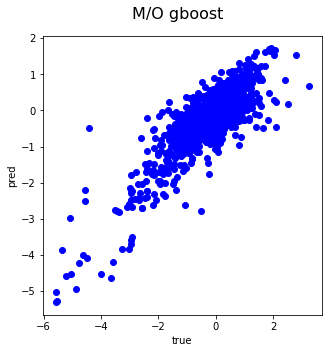

Mean squared error: 0.0423
Coefficient of determination: 0.3769


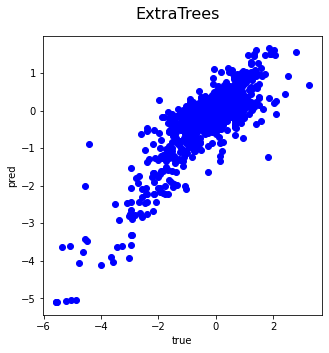

Mean squared error: 0.0438
Coefficient of determination: 0.3593


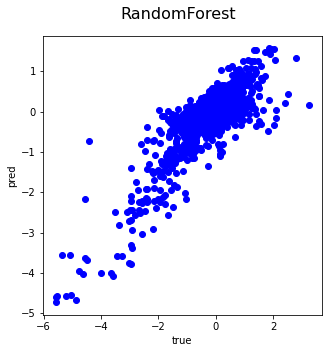

fold=1
Mean squared error: 0.1322
Coefficient of determination: -0.0309


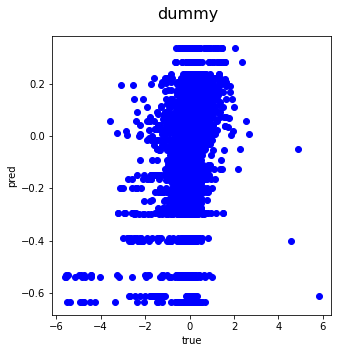

Mean squared error: 0.0609
Coefficient of determination: 0.2424


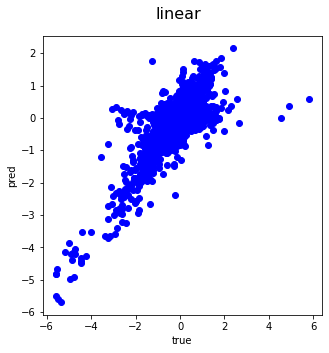

Mean squared error: 0.1066
Coefficient of determination: -0.0191


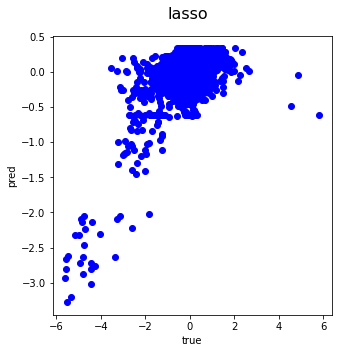

Mean squared error: 0.0930
Coefficient of determination: -0.0036


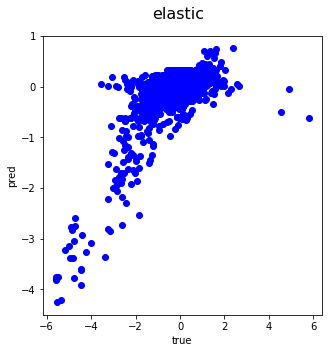

Mean squared error: 0.0608
Coefficient of determination: 0.2452


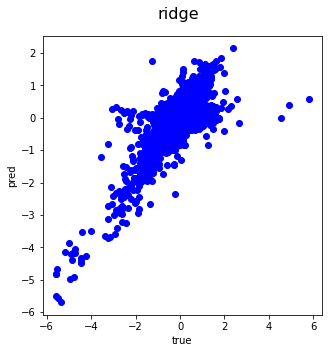

Mean squared error: 0.0624
Coefficient of determination: 0.2977


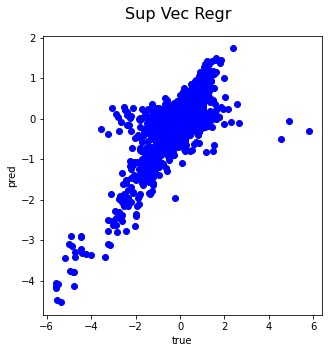

Mean squared error: 0.0632
Coefficient of determination: 0.3069


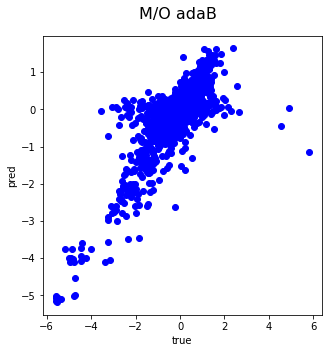

Mean squared error: 0.0627
Coefficient of determination: 0.2944


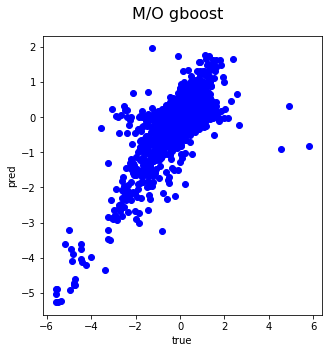

Mean squared error: 0.0609
Coefficient of determination: 0.3182


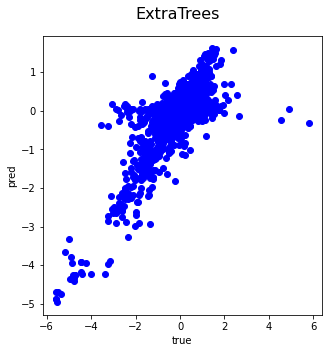

Mean squared error: 0.0649
Coefficient of determination: 0.2833


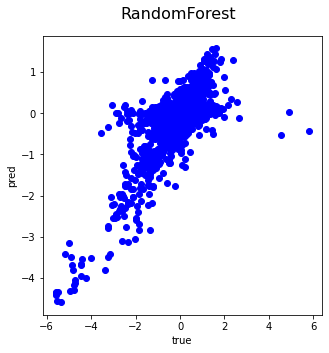

fold=2
Mean squared error: 0.1214
Coefficient of determination: -0.0209


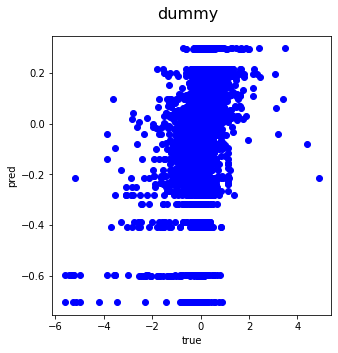

Mean squared error: 0.0661
Coefficient of determination: 0.1767


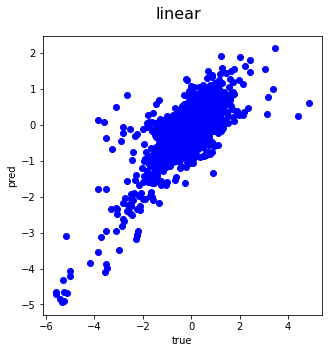

Mean squared error: 0.1015
Coefficient of determination: -0.0081


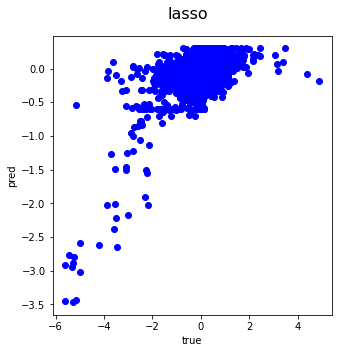

Mean squared error: 0.0924
Coefficient of determination: 0.0049


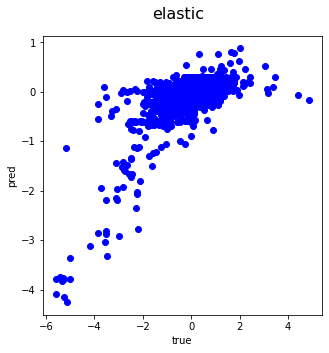

Mean squared error: 0.0660
Coefficient of determination: 0.1793


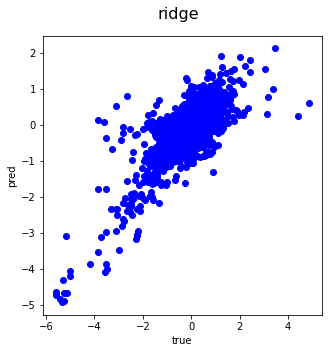

Mean squared error: 0.0697
Coefficient of determination: 0.2324


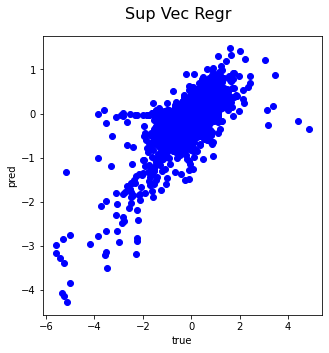

Mean squared error: 0.0683
Coefficient of determination: 0.2435


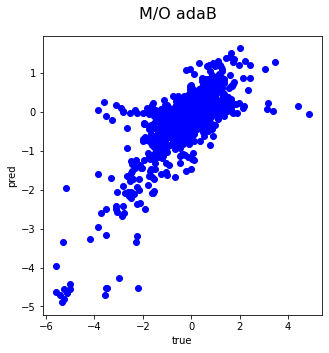

Mean squared error: 0.0686
Coefficient of determination: 0.2392


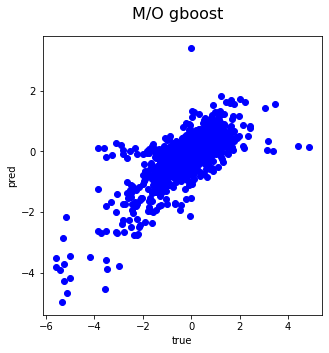

Mean squared error: 0.0692
Coefficient of determination: 0.2334


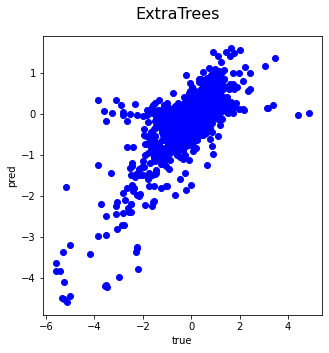

Mean squared error: 0.0739
Coefficient of determination: 0.2144


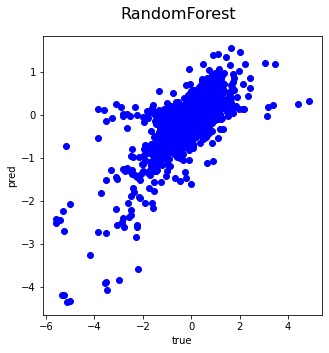

fold=3
Mean squared error: 0.1129
Coefficient of determination: -0.0144


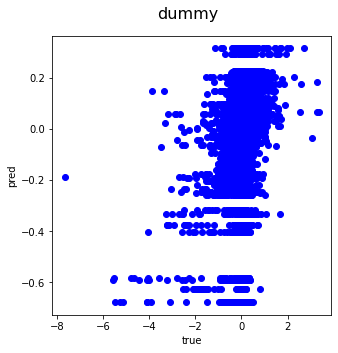

Mean squared error: 0.0500
Coefficient of determination: 0.2663


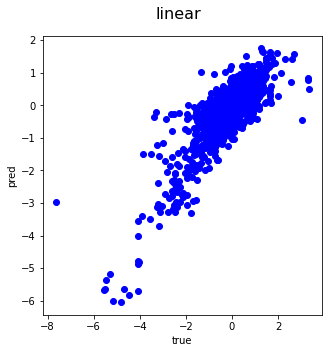

Mean squared error: 0.0935
Coefficient of determination: -0.0015


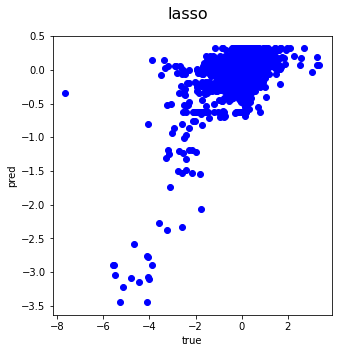

Mean squared error: 0.0836
Coefficient of determination: 0.0136


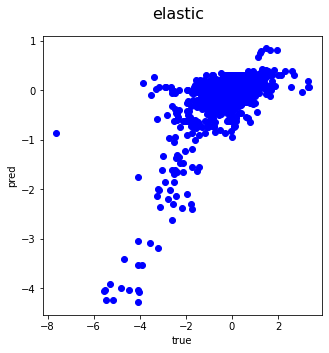

Mean squared error: 0.0499
Coefficient of determination: 0.2692


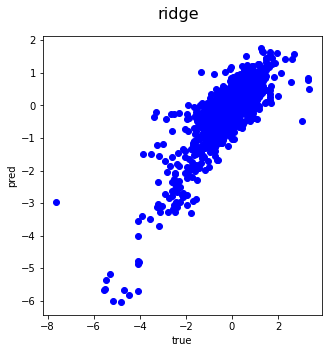

Mean squared error: 0.0558
Coefficient of determination: 0.2895


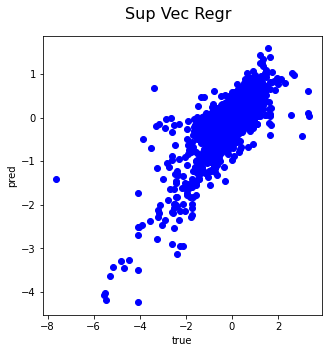

Mean squared error: 0.0548
Coefficient of determination: 0.3004


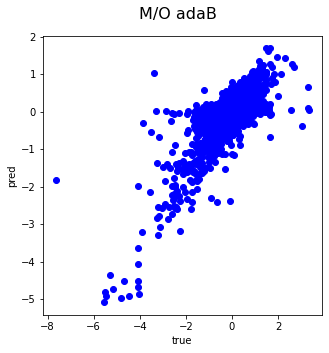

Mean squared error: 0.0531
Coefficient of determination: 0.2746


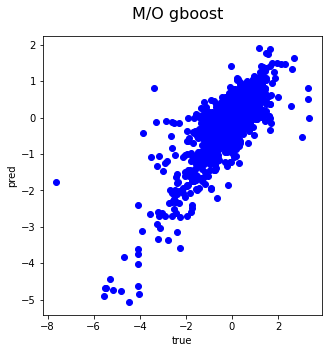

Mean squared error: 0.0522
Coefficient of determination: 0.3122


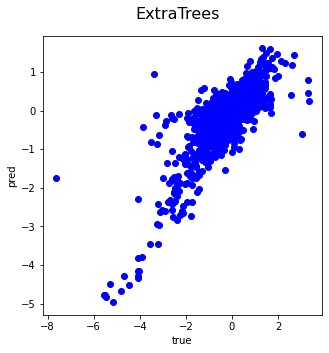

Mean squared error: 0.0552
Coefficient of determination: 0.2946


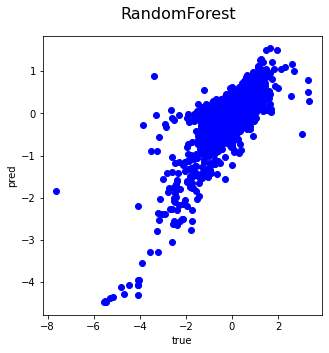

fold=4
Mean squared error: 0.0981
Coefficient of determination: -0.0204


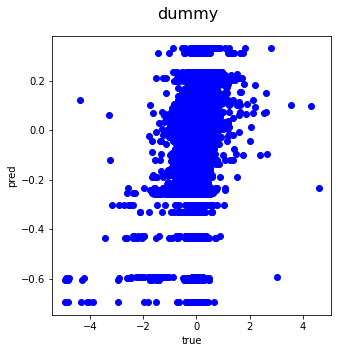

Mean squared error: 0.0524
Coefficient of determination: 0.2072


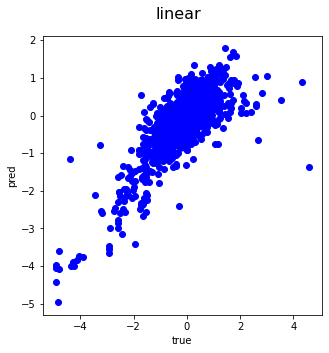

Mean squared error: 0.0816
Coefficient of determination: -0.0066


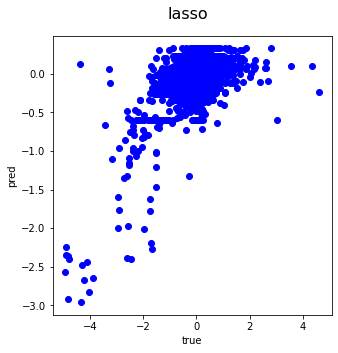

Mean squared error: 0.0757
Coefficient of determination: 0.0070


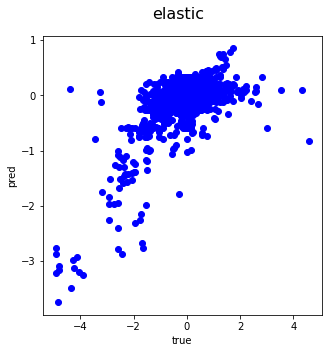

Mean squared error: 0.0524
Coefficient of determination: 0.2099


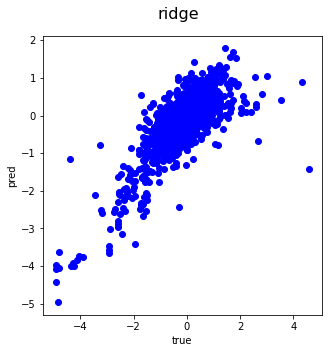

Mean squared error: 0.0519
Coefficient of determination: 0.2782


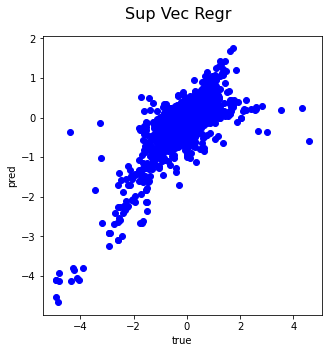

Mean squared error: 0.0546
Coefficient of determination: 0.2630


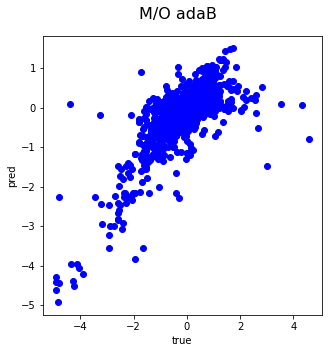

Mean squared error: 0.0534
Coefficient of determination: 0.2440


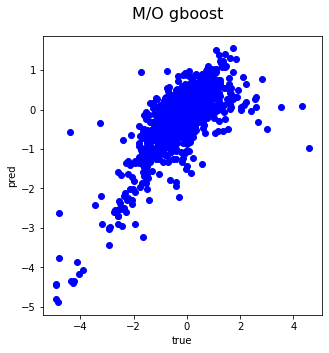

Mean squared error: 0.0521
Coefficient of determination: 0.2702


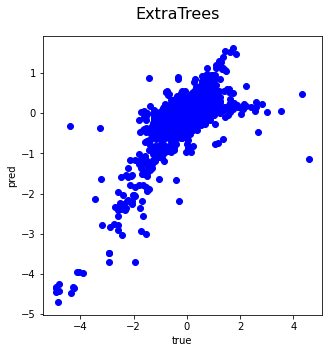

Mean squared error: 0.0529
Coefficient of determination: 0.2710


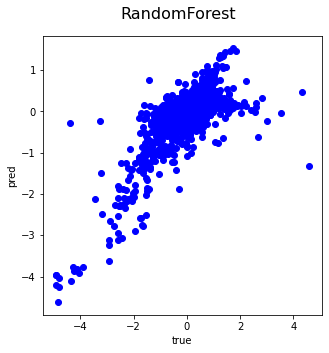

In [19]:
fold=0
mse = defaultdict(list)
r2 = defaultdict(list)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(range(len(pro_train_all))):
    print('fold='+str(fold))
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.asarray(pro_train_all)[train_index], np.asarray(pro_train_all)[test_index]
    y_train, y_test = np.asarray(met_train_all)[train_index], np.asarray(met_train_all)[test_index]
    for key in model_dict.keys():
        tmp_mse, tmp_r2 = model_eval(model_dict[key], key, X_train, X_test, y_train, y_test)
        mse[key].append(tmp_mse)
        r2[key].append(tmp_r2)
    fold+=1

In [51]:
mse_means = []
r2_means = []
for key in mse.keys():
    print(key)
    print('MSE= '+ str(np.mean(mse[key])) +'+/-' + str(np.std(mse[key])))
    mse_means.append(np.mean(mse[key]))
    print('Rsq= '+ str(np.mean(r2[key])) +'+/-' + str(np.std(r2[key])) )
    r2_means.append(np.mean(r2[key]))

dummy
MSE= 0.11335333423397889+/-0.01247389928481047
Rsq= -0.019610947892185128+/-0.00668520813548824
linear
MSE= 0.05462608819200034+/-0.007960666665292467
Rsq= 0.23417893046043084+/-0.03768199443977419
lasso
MSE= 0.0930245395100841+/-0.010120150940507971
Rsq= -0.006924595417140836+/-0.006890355545705236
elastic
MSE= 0.08315674365450025+/-0.008749348845825514
Rsq= 0.007510013460738823+/-0.006827569017466188
ridge
MSE= 0.054521977779175834+/-0.007942535726905698
Rsq= 0.2370885109455077+/-0.03789613809626191
Sup Vec Regr
MSE= 0.056482818308481786+/-0.00924018539288303
Rsq= 0.29137994078865886+/-0.0406800180924757
M/O adaB
MSE= 0.05736770330445331+/-0.008352252899663968
Rsq= 0.2925808167370586+/-0.03770174053806193
M/O gboost
MSE= 0.05632031683305091+/-0.008708781513776463
Rsq= 0.28124116843923996+/-0.043037006921641294
ExtraTrees
MSE= 0.055541610982598064+/-0.00911862311352806
Rsq= 0.2969312009793272+/-0.04600366988065311
RandomForest
MSE= 0.05804828854036429+/-0.010444483882424206
Rsq=

In [52]:
### get numpy array from values
#y = np.zeros(len(mse))
mse_arr = np.zeros((len(mse), 5))
i = 0
for key, values in mse.items():
    #y[i] = key
    mse_arr[i, :] = values
    i += 1
    
r2_arr = np.zeros((len(r2), 5))
i = 0
for key, values in r2.items():
    #y[i] = key
    r2_arr[i, :] = values
    i += 1
mse_hm = np.c_[mse_arr, mse_means]
r2_hm = np.c_[r2_arr, r2_means]

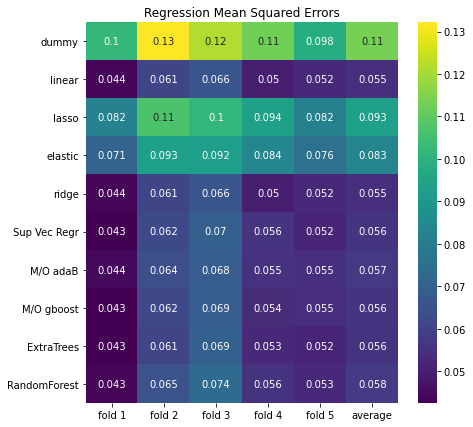

In [53]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(mse_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression Mean Squared Errors')
plt.savefig('MSE_yeast_metabolites_hm.svg')

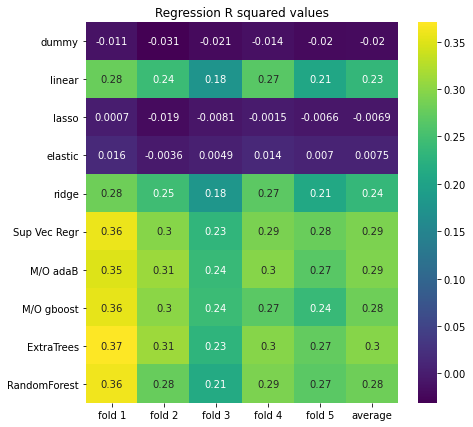

In [54]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(r2_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression R squared values')
plt.savefig('r2_yeast_metabolites_hm.svg')

# combined lipid/metabolite output


fold=0
Mean squared error: 0.1940
Coefficient of determination: -0.0151


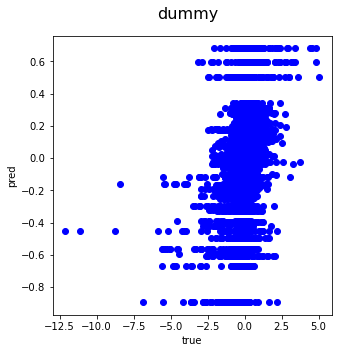

Mean squared error: 0.1066
Coefficient of determination: 0.2996


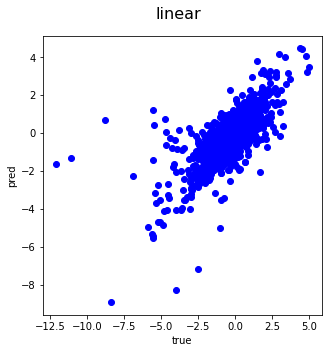

Mean squared error: 0.1719
Coefficient of determination: -0.0020


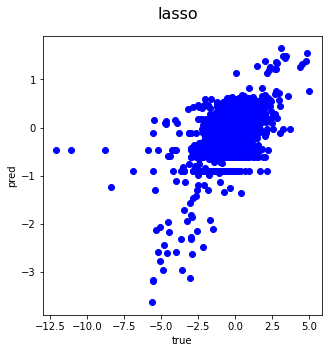

Mean squared error: 0.1562
Coefficient of determination: 0.0175


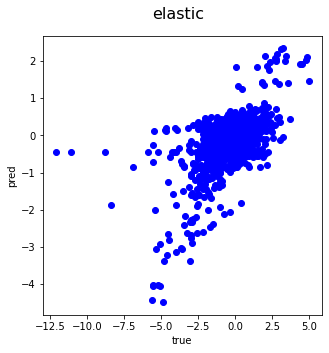

Mean squared error: 0.1064
Coefficient of determination: 0.3028


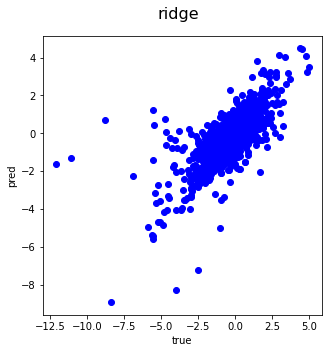

Mean squared error: 0.1085
Coefficient of determination: 0.3692


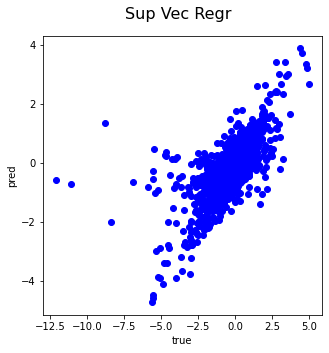

Mean squared error: 0.1028
Coefficient of determination: 0.3864


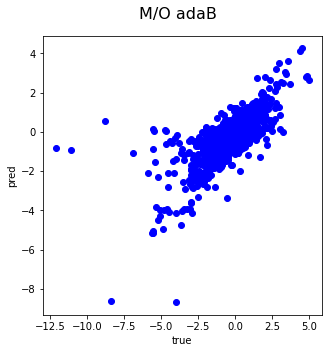

Mean squared error: 0.1030
Coefficient of determination: 0.3630


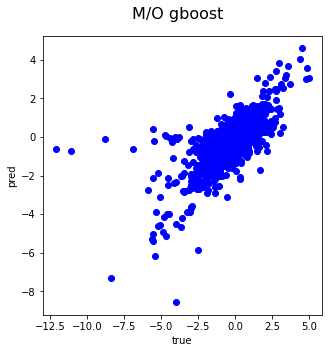

Mean squared error: 0.1053
Coefficient of determination: 0.3754


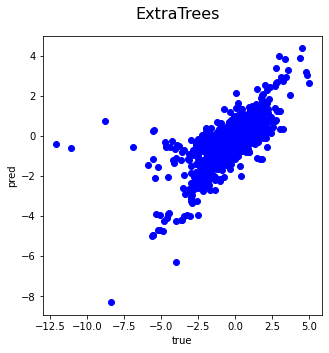

Mean squared error: 0.1105
Coefficient of determination: 0.3418


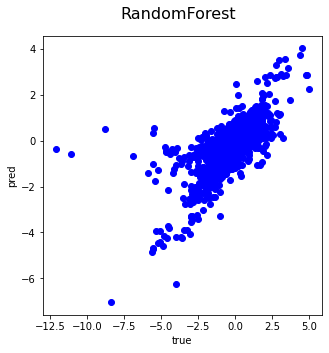

fold=1
Mean squared error: 0.2150
Coefficient of determination: -0.0303


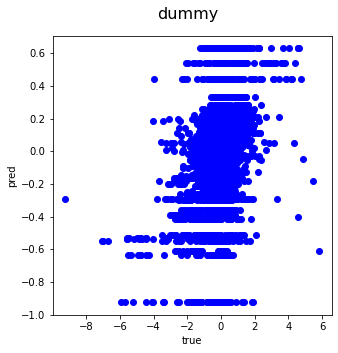

Mean squared error: 0.1175
Coefficient of determination: 0.2690


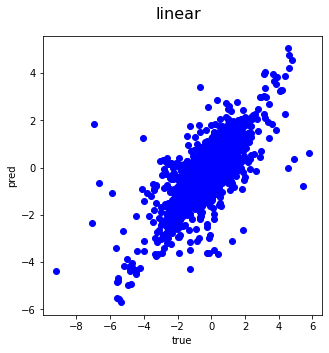

Mean squared error: 0.1883
Coefficient of determination: -0.0180


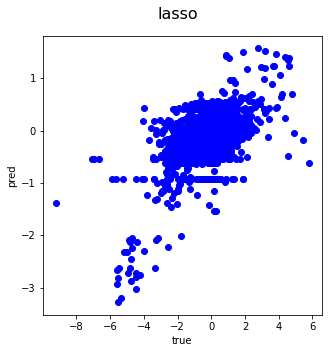

Mean squared error: 0.1708
Coefficient of determination: 0.0001


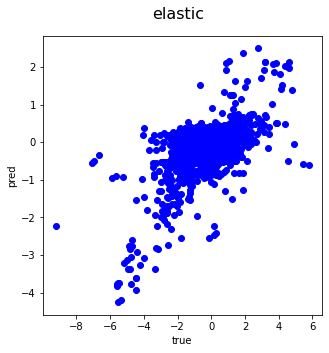

Mean squared error: 0.1171
Coefficient of determination: 0.2717


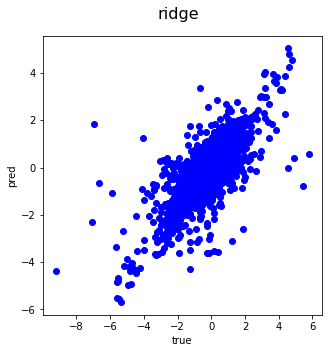

Mean squared error: 0.1173
Coefficient of determination: 0.3122


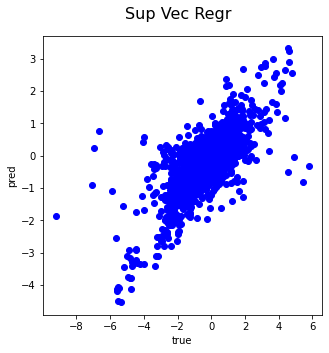

Mean squared error: 0.1118
Coefficient of determination: 0.3434


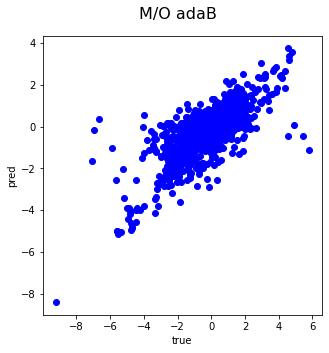

Mean squared error: 0.1166
Coefficient of determination: 0.3051


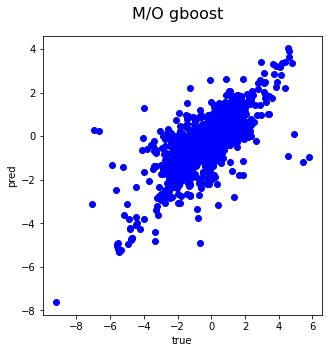

Mean squared error: 0.1158
Coefficient of determination: 0.3269


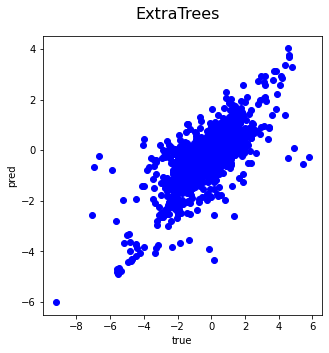

Mean squared error: 0.1214
Coefficient of determination: 0.3014


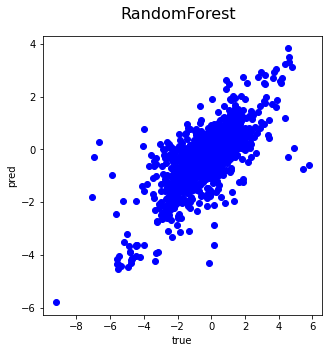

fold=2
Mean squared error: 0.1995
Coefficient of determination: -0.0214


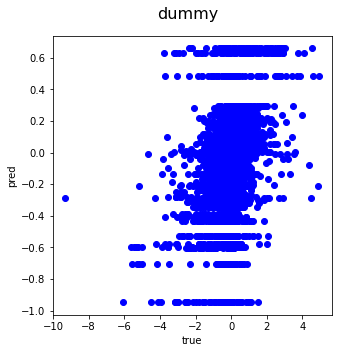

Mean squared error: 0.1197
Coefficient of determination: 0.2048


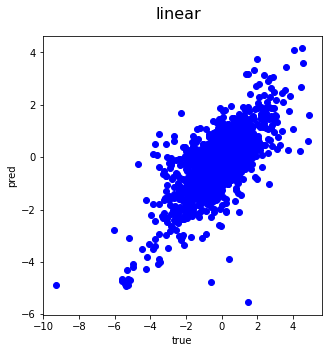

Mean squared error: 0.1788
Coefficient of determination: -0.0089


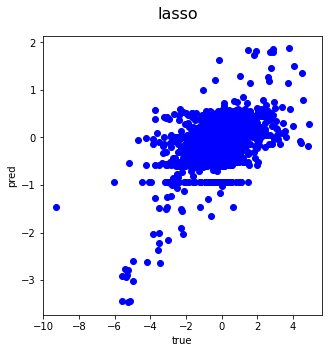

Mean squared error: 0.1673
Coefficient of determination: 0.0063


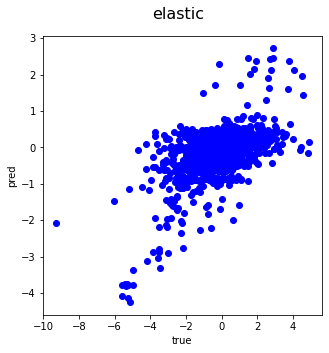

Mean squared error: 0.1193
Coefficient of determination: 0.2075


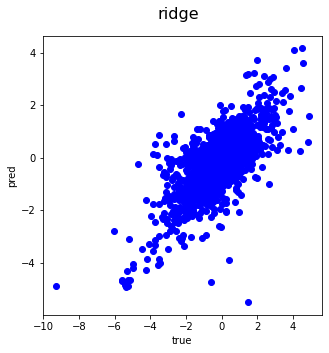

Mean squared error: 0.1235
Coefficient of determination: 0.2478


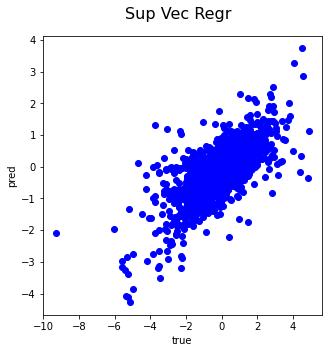

Mean squared error: 0.1214
Coefficient of determination: 0.2744


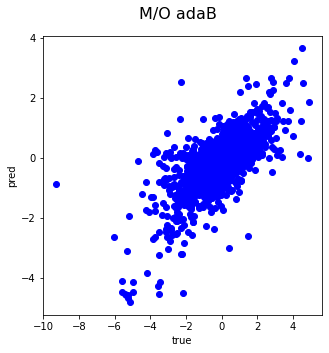

Mean squared error: 0.1265
Coefficient of determination: 0.2508


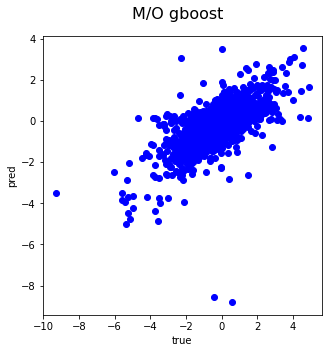

Mean squared error: 0.1245
Coefficient of determination: 0.2550


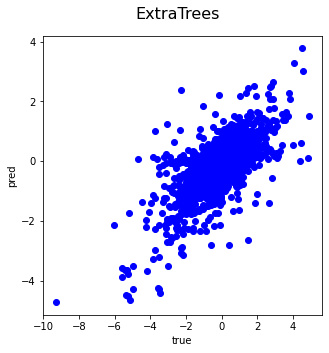

Mean squared error: 0.1329
Coefficient of determination: 0.2247


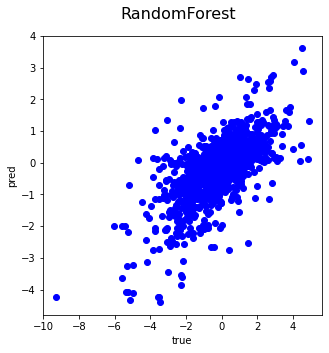

fold=3
Mean squared error: 0.1924
Coefficient of determination: -0.0180


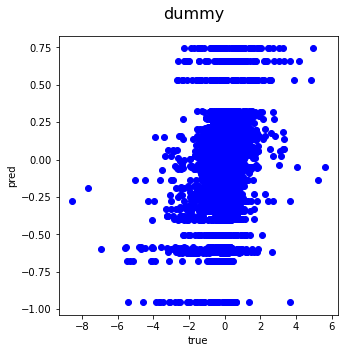

Mean squared error: 0.0973
Coefficient of determination: 0.2904


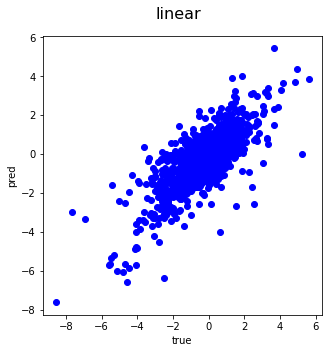

Mean squared error: 0.1707
Coefficient of determination: -0.0046


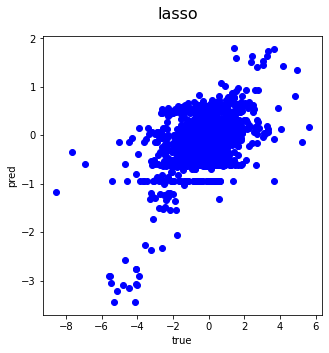

Mean squared error: 0.1562
Coefficient of determination: 0.0140


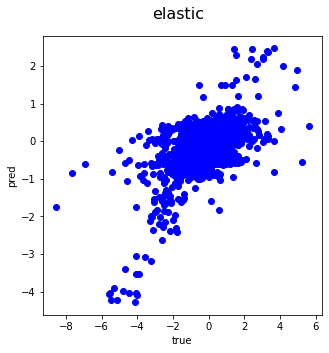

Mean squared error: 0.0970
Coefficient of determination: 0.2932


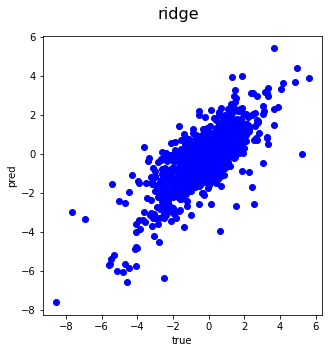

Mean squared error: 0.1057
Coefficient of determination: 0.3010


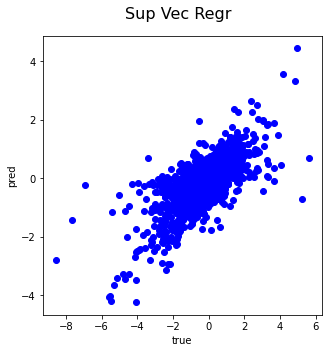

Mean squared error: 0.0980
Coefficient of determination: 0.3401


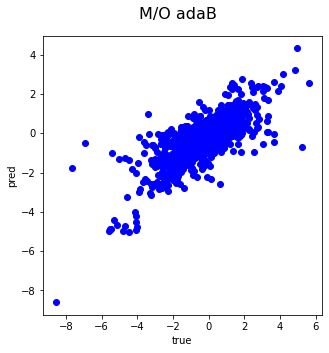

Mean squared error: 0.0997
Coefficient of determination: 0.2915


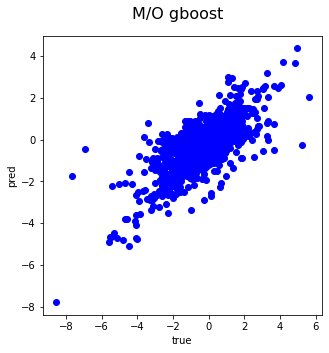

Mean squared error: 0.0997
Coefficient of determination: 0.3267


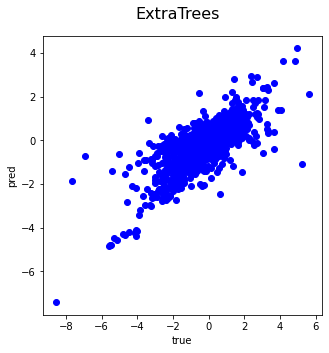

Mean squared error: 0.1051
Coefficient of determination: 0.3012


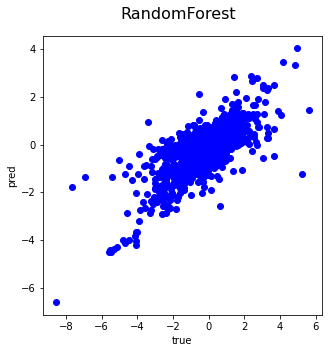

fold=4
Mean squared error: 0.1768
Coefficient of determination: -0.0214


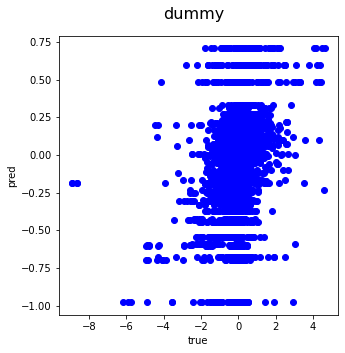

Mean squared error: 0.1024
Coefficient of determination: 0.2464


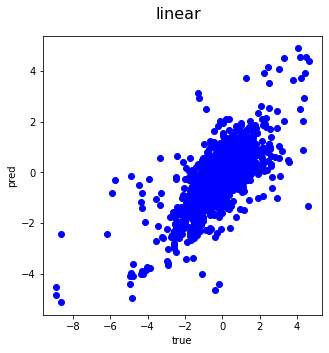

Mean squared error: 0.1584
Coefficient of determination: -0.0078


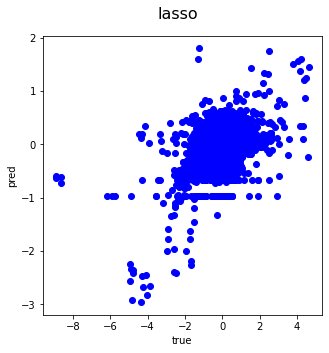

Mean squared error: 0.1467
Coefficient of determination: 0.0100


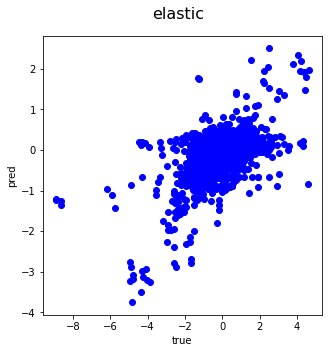

Mean squared error: 0.1022
Coefficient of determination: 0.2491


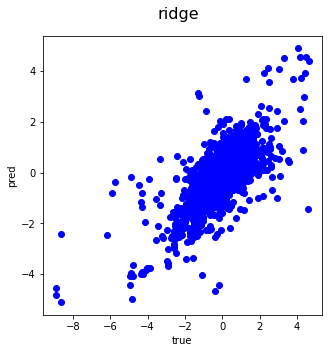

Mean squared error: 0.0991
Coefficient of determination: 0.3039


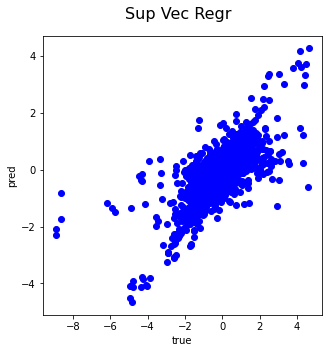

Mean squared error: 0.1004
Coefficient of determination: 0.3136


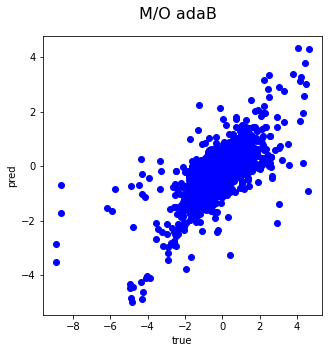

Mean squared error: 0.0950
Coefficient of determination: 0.2768


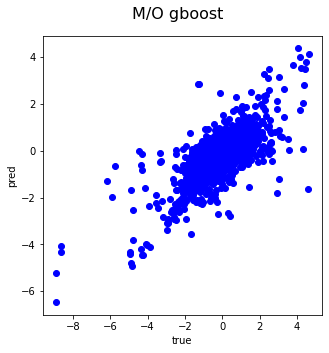

Mean squared error: 0.1017
Coefficient of determination: 0.2897


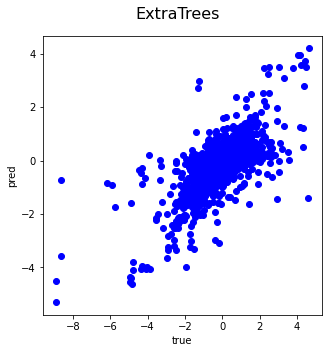

Mean squared error: 0.1068
Coefficient of determination: 0.2607


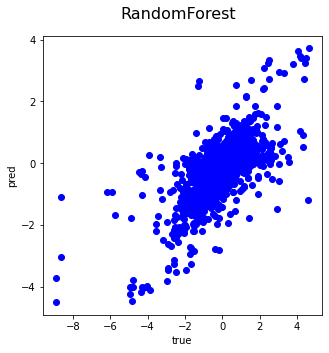

In [55]:
model_dict = {
    'dummy': DummyRegressor(),
    'linear': LinearRegression(),
    'lasso' : Lasso(),
    'elastic': ElasticNet(),
    'ridge': Ridge(),
    'Sup Vec Regr': MultiOutputRegressor(SVR()),
    'M/O adaB': MultiOutputRegressor(AdaBoostRegressor(n_estimators=500)),
    'M/O gboost': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=500)) , 
    'ExtraTrees': ExtraTreesRegressor(n_estimators=500),
    'RandomForest' : RandomForestRegressor(n_estimators=500)
}

fold=0
mse = defaultdict(list)
r2 = defaultdict(list)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(range(len(pro_train_all))):
    print('fold='+str(fold))
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.asarray(pro_train_all)[train_index], np.asarray(pro_train_all)[test_index]
    y_train, y_test = np.asarray(ml_train_all)[train_index], np.asarray(ml_train_all)[test_index]
    for key in model_dict.keys():
        tmp_mse, tmp_r2 = model_eval(model_dict[key], key, X_train, X_test, y_train, y_test)
        mse[key].append(tmp_mse)
        r2[key].append(tmp_r2)
    fold+=1


In [20]:
model_dict[key].predict(X_test).shape

(62, 273)

In [21]:
mse_means = []
r2_means = []
for key in mse.keys():
    print(key)
    print('MSE= '+ str(np.mean(mse[key])) +'+/-' + str(np.std(mse[key])))
    mse_means.append(np.mean(mse[key]))
    print('Rsq= '+ str(np.mean(r2[key])) +'+/-' + str(np.std(r2[key])) )
    r2_means.append(np.mean(r2[key]))

### get numpy array from values
#y = np.zeros(len(mse))
mse_arr = np.zeros((len(mse), 5))
i = 0
for key, values in mse.items():
    #y[i] = key
    mse_arr[i, :] = values
    i += 1
    
r2_arr = np.zeros((len(r2), 5))
i = 0
for key, values in r2.items():
    #y[i] = key
    r2_arr[i, :] = values
    i += 1
mse_hm = np.c_[mse_arr, mse_means]
r2_hm = np.c_[r2_arr, r2_means]

dummy
MSE= 0.11335333423397889+/-0.012473899284810479
Rsq= -0.019610947892185128+/-0.00668520813548824
linear
MSE= 0.054638990776248474+/-0.007951261795623409
Rsq= 0.23417125556025362+/-0.03757750000299424
lasso
MSE= 0.0930245395100841+/-0.010120150940507975
Rsq= -0.006924595417140834+/-0.00689035554570524
elastic
MSE= 0.08315674365450025+/-0.008749348845825514
Rsq= 0.007510013460738823+/-0.006827569017466192
ridge
MSE= 0.05452197777917585+/-0.007942535726905698
Rsq= 0.23708851094550765+/-0.03789613809626191
Sup Vec Regr
MSE= 0.0564828183084818+/-0.00924018539288303
Rsq= 0.2913799407886587+/-0.040680018092475664
M/O adaB
MSE= 0.05710160630320843+/-0.008159784286990211
Rsq= 0.29297275886502505+/-0.03732359572923112
M/O gboost
MSE= 0.05606717508865557+/-0.008977477534804879
Rsq= 0.2812639026637994+/-0.04171951000978212
ExtraTrees
MSE= 0.05532435682399963+/-0.009114231659692194
Rsq= 0.30218110066797665+/-0.048362269399286395
RandomForest
MSE= 0.058119138599680945+/-0.010354050287194955
Rs

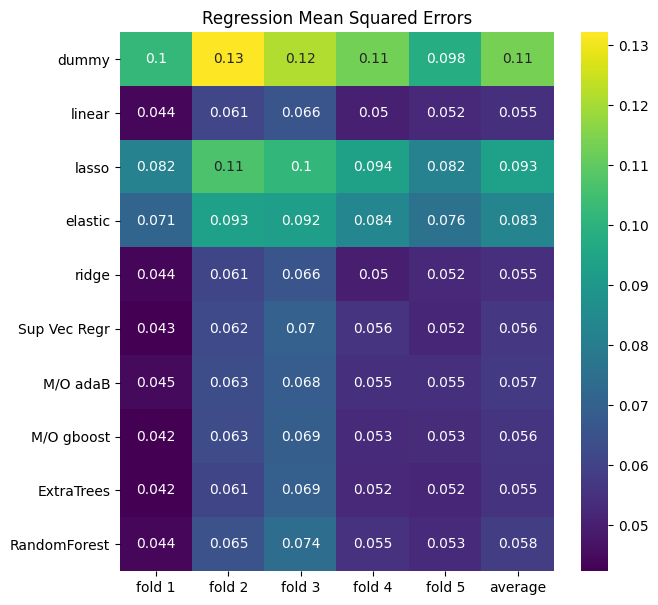

In [22]:
sns.reset_defaults()
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(mse_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression Mean Squared Errors')
plt.savefig('MSE_yeast_met_and_lip_hm_tight_imp.svg', bbox_inches='tight')

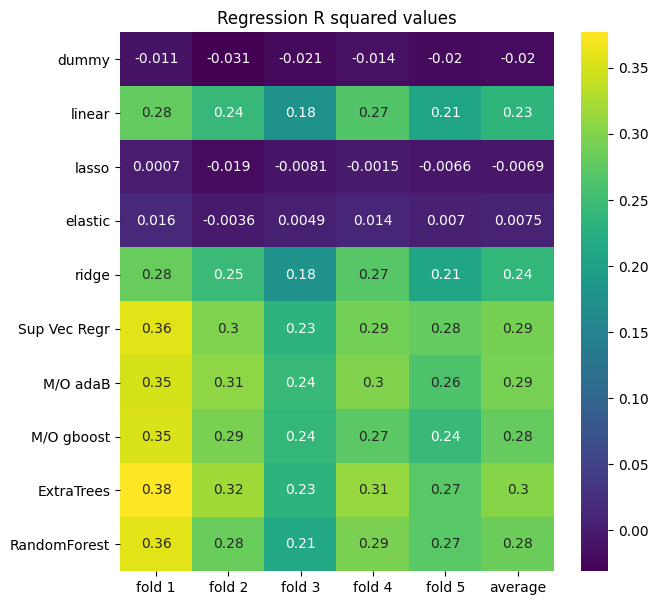

In [23]:
plt.rcParams['figure.figsize'] = 7,7
sns.heatmap(r2_hm, cmap='viridis',
            yticklabels=mse.keys(), annot=True,
            xticklabels=['fold 1','fold 2', 'fold 3' , 'fold 4', 'fold 5', 'average'])
plt.title('Regression R squared values')
plt.savefig('r2_yeast_met_and_lip_hm_imp.svg', bbox_inches='tight')